In [0]:
!pip install keras==2.1.6

     |████████████████████████████████| 348kB 4.8MB/s 
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [0]:
import os
os.chdir('/gdrive/My Drive')

In [0]:
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp inputs/keras-pretrained-models/*notop* ~/.keras/models/
!cp inputs/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp inputs/keras-pretrained-models/resnet50* ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
mkdir: cannot create directory ‘/root/.keras/models’: File exists


In [0]:
import numpy as np 
import pandas as pd # data processing
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import h5py
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [0]:
base_h5 = os.path.join('inputs', 'mias-mammography', 'all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v] 
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
# save data to disk
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(5)

,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan
151,F,NORM,NaN,mdb149,nan,NaN,NaN,mdb149.pgm,tiffs/mdb149.tif
196,D,NORM,NaN,mdb194,nan,NaN,NaN,mdb194.pgm,tiffs/mdb194.tif
19,G,CIRC,49.0,mdb019,B,653.0,477.0,mdb019.pgm,tiffs/mdb019.tif
283,G,NORM,NaN,mdb276,nan,NaN,NaN,mdb276.pgm,tiffs/mdb276.tif
65,D,NORM,NaN,mdb065,nan,NaN,NaN,mdb065.pgm,tiffs/mdb065.tif


Using TensorFlow backend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe65d084828>,
      dtype=object)

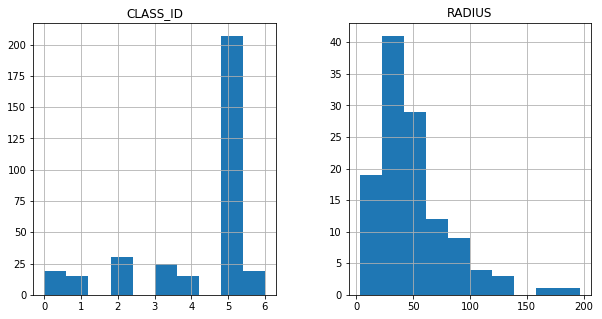

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])
mammo_df['CLASS_VEC'] = mammo_df['CLASS_ID'].map(lambda x: to_categorical(x, 
                                                                          num_classes=len(class_enc.classes_)))
mammo_df[['CLASS_ID', 'RADIUS', 'SEVERITY']].hist(figsize = (10, 5))

In [0]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID,CLASS_VEC
42,G,NORM,NaN,mdb042,nan,NaN,NaN,mdb042.pgm,tiffs/mdb042.tif,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


New Data Size: 1300 Old Size: 247


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe659e25668>,
      dtype=object)

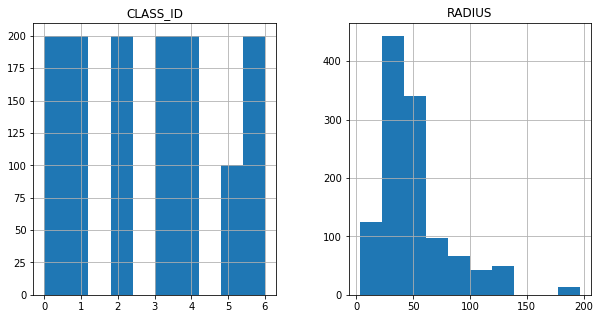

In [0]:
train_df = raw_train_df.groupby(['CLASS', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['CLASS_ID', 'RADIUS']].hist(figsize = (10, 5))

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (192, 192) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2,
                             preprocessing_function = preprocess_input)

In [0]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [0]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               train_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one  batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1300 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1300 images


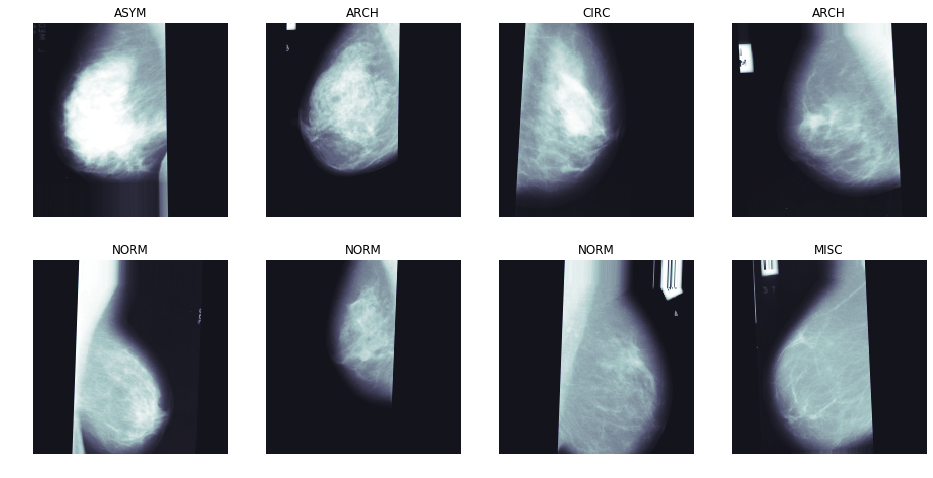

In [0]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % (class_enc.classes_[np.argmax(c_y,-1)]))
    c_ax.axis('off')

In [0]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(len(class_enc.classes_), activation = 'softmax')(dr_steps) # linear is what 16bit did
mammo_model = Model(inputs = [in_lay], outputs = [out_layer])

mammo_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])

mammo_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 6, 6, 512)    14714688    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 6, 6, 512)    2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

In [0]:
!rm -rf ~/.keras # clean up the model / make space for other things

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('mammo_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
mammo_model.fit_generator(train_gen, 
                                  steps_per_epoch = 36,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 6, 
                                  callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
36/36 [==============================] - 21s 571ms/step - loss: 1.7947 - categorical_accuracy: 0.2959 - val_loss: 1.3542 - val_categorical_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 1.35420, saving model to mammo_result_weights.best.hdf5
Epoch 2/6
36/36 [==============================] - 16s 436ms/step - loss: 1.3831 - categorical_accuracy: 0.4948 - val_loss: 0.9861 - val_categorical_accuracy: 0.7021

Epoch 00002: val_loss improved from 1.35420 to 0.98606, saving model to mammo_result_weights.best.hdf5
Epoch 3/6
36/36 [==============================] - 16s 441ms/step - loss: 1.1339 - categorical_accuracy: 0.6120 - val_loss: 0.8000 - val_categorical_accuracy: 0.7646

Epoch 00003: val_loss improved from 0.98606 to 0.79997, saving model to mammo_result_weights.best.hdf5
Epoch 4/6
36/36 [==============================] - 15s 415ms/step - loss: 0.9114 - categorical_accuracy: 0.6915 - val_loss: 0.6524 - val_categoric

In [0]:
# load the best version of the model
mammo_model.load_weights(weight_path)

In [0]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in mammo_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

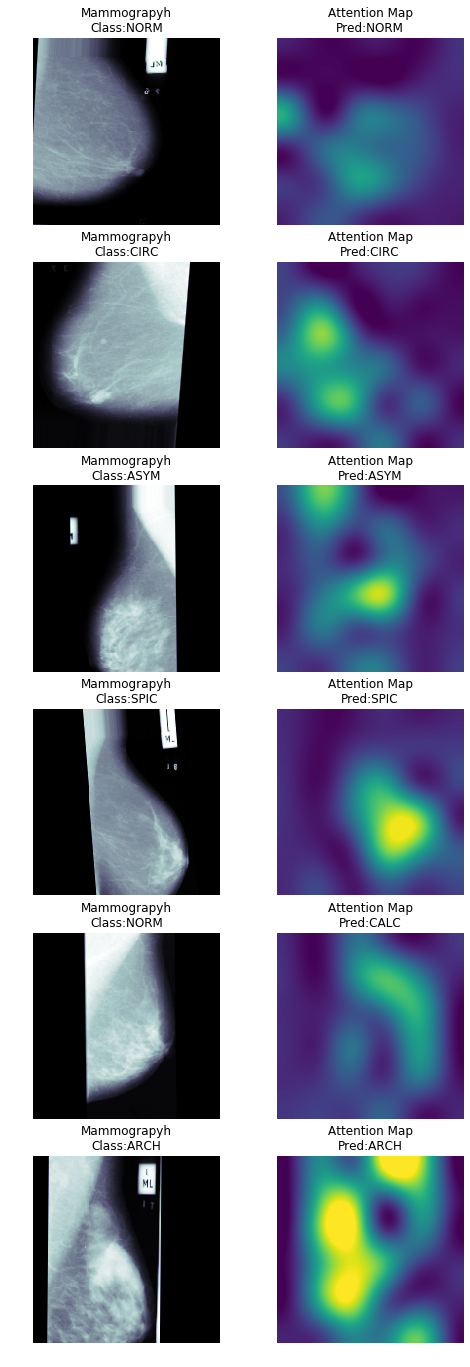

In [0]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [mammo_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_label = class_enc.classes_[np.argmax(test_Y[c_idx])]
    img_ax.set_title('Mammograpyh\nClass:%s' % (real_label))
    pred_confidence = class_enc.classes_[np.argmax(mammo_model.predict(cur_img)[0],-1)]
    attn_ax.set_title('Attention Map\nPred:%s' % (pred_confidence))
fig.savefig('attention_map.png', dpi = 300)

In [0]:
pred_Y = mammo_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y,-1)
test_Y_cat = np.argmax(test_Y, -1)

1024/1024 [==============================] - 4s 4ms/step


              precision    recall  f1-score   support

        ARCH       0.91      0.95      0.93       154
        ASYM       0.89      0.93      0.91       161
        CALC       0.84      0.93      0.88       161
        CIRC       0.86      0.89      0.88       164
        MISC       0.93      0.96      0.94       156
        NORM       0.79      0.32      0.46        71
        SPIC       0.89      0.90      0.90       157

   micro avg       0.88      0.88      0.88      1024
   macro avg       0.87      0.84      0.84      1024
weighted avg       0.88      0.88      0.87      1024



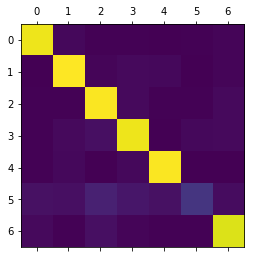

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y_cat, pred_Y_cat))
print(classification_report(test_Y_cat, pred_Y_cat, target_names = class_enc.classes_))